
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

Le projet a été développé à l'aide de Alice Breton, étudiante à la maîtrise en génie informatique. Elle a suivi le cours lors de la session Hiver 2019.



# Projet : Débordement d'égouts

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/a238b752c33a41d9803c2cdde6bfc929

Ce calepin Jupyter de base permet de charger et de nettoyer les données fournies. La dernière section détaille la génération du fichier des prédictions afin de le soumettre sur Kaggle dans le bon format.

Dans un premier temps, vous devrez récupérer l'archive *data.zip* sur Moodle. Ce dossier contient les fichiers suivants :
- surverses.csv
- precipitation.csv
- ouvrages-surverses.csv
- test.csv

Veuillez le décompresser dans le répertoire de ce calepin.

Le fichier *surverse.csv* répertorie s'il y a surverse (1) ou non (0) au cours de la journée pour les 170 ouvrages de débordement de 2013 à 2018 pour les mois de mai à octobre (inclusivement). Des renseignements additionnels sur les données sont disponibles à l'adresse suivante :

http://donnees.ville.montreal.qc.ca/dataset/debordement


Le fichier *precipitation.csv* contient les précipitations horaires en dixième de *mm* enregistrées à 5 stations pluviométriques de 2013 à 2019 :
- McTavish (7024745)
- Ste-Anne-de-Bellevue (702FHL8)
- Montreal/Pierre Elliott Trudeau Intl (702S006)
- Montreal/St-Hubert (7027329)
- L’Assomption (7014160)

Plus d'informations sur les précipitations sont disponibles à l'adresse suivante :

https://climat.meteo.gc.ca/climate_data/hourly_data_f.html?hlyRange=2008-01-08%7C2019-11-12&dlyRange=2002-12-23%7C2019-11-12&mlyRange=%7C&StationID=30165&Prov=QC&urlExtension=_f.html&searchType=stnName&optLimit=yearRange&StartYear=1840&EndYear=2019&selRowPerPage=25&Line=17&searchMethod=contains&Month=11&Day=12&txtStationName=montreal&timeframe=1&Year=2019

Le fichier *ouvrages-surverses.csv* contient différentes caractéristiques des ouvrages de débordement. 

http://donnees.ville.montreal.qc.ca/dataset/ouvrage-surverse

Le fichier *test.csv* contient les ouvrages et les jours pour lesquels vous devez prédire s'il y a eu surverse (true) ou non (false). Notez que l'on s'intéresse ici à 5 ouvrages de débordement localisés tout autour de l'Ile de Montréal :
- 3260-01D dans Rivière-des-Prairies 
- 3350-07D dans Ahunstic 
- 4240-01D dans Pointe-aux-Trembles 
- 4350-01D dans le Vieux-Montréal 
- 4380-01D dans Verdun

#### Remarque

Dans le projet, on ne s'intéresse qu'aux surverses occasionnées par les précipitations. On ignore les surverses occasionnées par 
- fonte de neige (F)
- travaux planifiés et entretien (TPL)
- urgence (U)
- autre (AUT)

On suppose que lorsqu'il n'y a pas de raison pour la surverse, il s'agit d'une surverse causée par les précipitations. Puisque Nous nous intéresserons uniquement aux surverses occasionnées par les précipitations liquides, nous ne considérons que les mois de mai à octobre inclusivement.

In [62]:
using CSV, DataFrames, Statistics, Dates, Gadfly, Random, LinearAlgebra, GLM, Distributions
include("functions.jl");

# Chargement des données et nettoyage préliminaire

## Chargement des surverses

In [63]:
data = CSV.read("data/surverses.csv",missingstring="-99999")
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String⍰
1,0642-01D,2013-05-01,0,missing
2,0642-01D,2013-05-02,0,missing
3,0642-01D,2013-05-03,0,missing
4,0642-01D,2013-05-04,0,missing
5,0642-01D,2013-05-05,0,missing


## Nettoyage des données sur les surverses

#### Extraction des surverses pour les mois de mai à octobre inclusivement

In [64]:
data = filter(row -> month(row.DATE) > 4, data) 
data = filter(row -> month(row.DATE) < 11, data) 
length(data[1])

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[64]:3
└ @ Core In[64]:3


177155

#### Remplacement des valeurs *missing* dans la colonne :RAISON par "Inconnue"

In [65]:
raison = coalesce.(data[:,:RAISON],"Inconnue")
data[!,:RAISON] = raison
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String
1,0642-01D,2013-05-01,0,Inconnue
2,0642-01D,2013-05-02,0,Inconnue
3,0642-01D,2013-05-03,0,Inconnue
4,0642-01D,2013-05-04,0,Inconnue
5,0642-01D,2013-05-05,0,Inconnue


#### Exlusion des surverses coccasionnées par d'autres facteurs que les précipitations liquides

Ces facteurs correspondent à : 
- la fonte de neige (F), 
- les travaux planifiés et entretien (TPL)
- urgence (U)
- autre (AUT)

In [66]:
data = filter(row -> row.RAISON ∈ ["P","Inconnue","TS"], data) 
select!(data, [:NO_OUVRAGE, :DATE, :SURVERSE])
length(data[1])

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[66]:3
└ @ Core In[66]:3


176667

#### Exclusion des lignes où :SURVERSE est manquante

In [67]:
surverse_df = dropmissing(data, disallowmissing=true)
first(surverse_df,5)

,NO_OUVRAGE,DATE,SURVERSE
,String,Date,Int64
1,0642-01D,2013-05-01,0
2,0642-01D,2013-05-02,0
3,0642-01D,2013-05-03,0
4,0642-01D,2013-05-04,0
5,0642-01D,2013-05-05,0


## Chargement des précipitations

In [68]:
data = CSV.read("data/precipitations.csv",missingstring="-99999")
rename!(data, Symbol("St-Hubert")=>:StHubert)
first(data,5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-01-01,0,0,0,0,0,missing
2,2013-01-01,1,0,0,0,0,missing
3,2013-01-01,2,0,0,0,0,missing
4,2013-01-01,3,0,0,0,0,missing
5,2013-01-01,4,0,0,0,0,missing


## Nettoyage des données sur les précipitations

#### Extraction des précipitations des mois de mai à octobre inclusivement

In [69]:
data = filter(row -> month(row.date) > 4, data) 
data = filter(row -> month(row.date) < 11, data) 
first(data,5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-05-01,0,0,0,0,0,missing
2,2013-05-01,1,0,0,0,0,missing
3,2013-05-01,2,0,0,0,0,missing
4,2013-05-01,3,0,0,0,0,missing
5,2013-05-01,4,0,0,0,0,missing


In [70]:
# Remplacer les valeurs manquantes
# On veut remplacer les données manquante grâce à une simple régression linéaire (Ridge).
# Pour ce faire, chaque station météo agira comme variable explicative pour les 4 autres
# On drop les rangées dont les 5valeurs sont missing

data_full = deepcopy(data)
dropmissing!(data, disallowmissing=true)

models = Dict()

for i = 1:length(data_full[:, 1])
    if any(ismissing, data_full[i, 3:7]) #ismissing c est pas une variable mais une méthode de Julia, 3:7 pour les 5 stations
        missing = []
        notmissing = []
        for j=3:7 #on passe à travers les 5 colonnes pour regarder celles qui sont missing ou non
            if ismissing(data_full[i, j])
                push!(missing, names(data_full)[j]) #push généralisé à tous les conteneurs
                #Le point d exclamation pour dire à la fonction de modifier le conteneur qu on lui passe
            else
                push!(notmissing, names(data_full)[j])
            end
        end
        
        if length(notmissing) > 0 #si on a 5 missing sur la ligne on peut juste rien prédire donc on skip ça
            for m in missing #m c est la station à prédire
                if !haskey(models, (m, notmissing)) #ça véfirie si dans le dictionnaire models il y a la key (m, notmissing)
                    models[(m, notmissing)] = CoeffRidge(data, m, notmissing) #on change la case dans le dico palr le coef que la fonction nous retourne
                end
                data_full[i, m] = round(convert(Vector{Float64}, data_full[i, notmissing])' * models[(m, notmissing)]) # on ajoute à la case manque la nouvelle valeur = x*Beta
            end
        end
    end
end

dropmissing!(data_full)
models

Dict{Any,Any} with 45 entries:
  (:McTavish, Any[:Bellevue, :T… => [0.0128209, 0.448309, 0.468447]
  (:StHubert, Any[:McTavish, :B… => [0.73924, 0.0325755]
  (:Trudeau, Any[:McTavish])     => [0.710843]
  (:Trudeau, Any[:McTavish, :Be… => [0.489542, 0.385939, 0.0266655, -0.00633792]
  (:Assomption, Any[:McTavish, … => [0.411276, 0.124687, 0.0322526]
  (:Assomption, Any[:Bellevue, … => [0.115775, 0.185574, 0.2642]
  (:StHubert, Any[:McTavish, :B… => [0.707344, 0.0583761, 0.0168947]
  (:McTavish, Any[:Bellevue, :A… => [0.0144956, 0.107433, 0.418237, 0.449324]
  (:Trudeau, Any[:McTavish, :Be… => [0.424684, 0.455286, 0.0434431]
  (:Assomption, Any[:McTavish, … => [0.384241, 0.139331]
  (:Assomption, Any[:McTavish, … => [0.391399, 0.122426]
  (:Trudeau, Any[:StHubert])     => [0.551708]
  (:StHubert, Any[:McTavish, :B… => [0.66944, 0.0487652, 0.0943164]
  (:StHubert, Any[:McTavish, :B… => [0.66327, 0.0408232, 0.110619, -0.0169656]
  (:Bellevue, Any[:McTavish, :T… => [0.120491, 0.578885]
  (

## Extraction variables explicatives (Maude L.)

In [71]:
# Maximum de précipitations en 1 heure dans une journée.
X_pcp_max = by(data_full, :date,  McTavish = :McTavish=>maximum, Bellevue = :Bellevue=>maximum, 
   Assomption = :Assomption=>maximum, Trudeau = :Trudeau=>maximum, StHubert = :StHubert=>maximum)

# Somme des précipitations dans une journée
X_pcp_sum = by(data_full, :date,  McTavish = :McTavish=>sum, Bellevue = :Bellevue=>sum, 
   Assomption = :Assomption=>sum, Trudeau = :Trudeau=>sum, StHubert = :StHubert=>sum)

# Précipitation à chaque heure pour chaque journée
X_pcp_hour = data_full

# Somme des précipitations des 2 heures précédentes

X_pcp_three_hours = copy(data_full)
buffer = copy(data_full)
for i=3:7
    for j=1:length(data_full[:,2])
        if (j > 2)
            X_pcp_three_hours[j, i] = (buffer[(j-2), i] + buffer[(j-1), i] + buffer[j,i])
        else
            X_pcp_three_hours[j, i] = buffer[j, i]
        end
    end
end

# Somme des précipitations des 2 jours précédents

X_pcp_three_days = copy(X_pcp_sum)
buffer = copy(X_pcp_sum)
for i=2:6
    for j=1:length(X_pcp_sum[:,2])
        if (j > 2)
            X_pcp_three_days[j, i] = (buffer[(j-2), i] + buffer[(j-1), i] + buffer[j,i])
        else
            X_pcp_three_days[j, i] = buffer[j, i]
        end
    end
end


# Mois de la prédiction pour chaque ouvrage
X_date = DataFrame(NO_OUVRAGE=surverse_df[:,:NO_OUVRAGE], MOIS=zeros(Int64,length(surverse_df[:,1])), SURVERSE=surverse_df[:,:SURVERSE])
for i=1:length(surverse_df[:,1])
    X_date[i,:MOIS] = month(surverse_df[i,:DATE])
end

X_mois = DataFrame(MOIS=["Mai", "Juin", "Juillet", "Août", "Septembre", "Octobre"], RivierePrairie=zeros(Int64,6), Ahuntsic=zeros(Int64,6), PointeAuxTrembles=zeros(Int64,6), VieuxMontreal=zeros(Int64,6), Verdun=zeros(Int64,6))
for j=1:length(X_date[:,1])
    if(X_date[j,1] == "3260-01D")
        X_mois[(X_date[j,2]-4),:RivierePrairie] += (X_date[j,3])
    elseif (X_date[j,1] == "3350-07D")
        X_mois[(X_date[j,2]-4),:Ahuntsic] += (X_date[j,3])
    elseif (X_date[j,1] == "4240-01D")
        X_mois[(X_date[j,2]-4),:PointeAuxTrembles] += (X_date[j,3])
    elseif (X_date[j,1] == "4350-01D")
        X_mois[(X_date[j,2]-4),:VieuxMontreal] += (X_date[j,3])
    elseif (X_date[j,1] == "4380-01D")
        X_mois[(X_date[j,2]-4),:Verdun] += (X_date[j,3])
    end
end

# Analyse exploratoire

Cette section consitue une analyse exploratoire superficielle permettant de voir s'il existe un lien entre les précipitations et les surverses.

Prenons arbitrairement l'ouvrage de débordement près du Bota-Bota (4350-01D). La station météorologique la plus proche est McTavish. Prenons deux variables explicatives simple :
- la somme journalière des précipitations
- le taux horaire maximum journalier de précipitations

#### Calcul de la quantité journalière de précipitations pour chacune des stations météorologiques

In [72]:
pcp_sum = by(data_full, :date,  McTavish = :McTavish=>sum, Bellevue = :Bellevue=>sum, 
   Assomption = :Assomption=>sum, Trudeau = :Trudeau=>sum, StHubert = :StHubert=>sum)
first(pcp_sum ,5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2013-05-01,0,0,0,0,0
2,2013-05-02,0,0,0,0,0
3,2013-05-03,0,0,0,0,0
4,2013-05-04,0,0,0,0,0
5,2013-05-05,0,0,0,0,0


#### Extraction du taux horaire journalier maximum des précipitations pour chacune des stations météorologiques

In [73]:
pcp_max = by(data_full, :date,  McTavish = :McTavish=>maximum, Bellevue = :Bellevue=>maximum, 
   Assomption = :Assomption=>maximum, Trudeau = :Trudeau=>maximum, StHubert = :StHubert=>maximum)
first(pcp_max,5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2013-05-01,0,0,0,0,0
2,2013-05-02,0,0,0,0,0
3,2013-05-03,0,0,0,0,0
4,2013-05-04,0,0,0,0,0
5,2013-05-05,0,0,0,0,0


In [74]:
pcp_pluie = by(data_full, :date,  McTavish = :McTavish=>maximum, Bellevue = :Bellevue=>maximum, 
   Assomption = :Assomption=>maximum, Trudeau = :Trudeau=>maximum, StHubert = :StHubert=>maximum)
first(pcp_max,5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2013-05-01,0,0,0,0,0
2,2013-05-02,0,0,0,0,0
3,2013-05-03,0,0,0,0,0
4,2013-05-04,0,0,0,0,0
5,2013-05-05,0,0,0,0,0


#### Inclusion dans un dataframe de ces deux variables explicatives potentielles

In [75]:
ouvrage = "4350-01D"

df = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)

x₁ = Array{Int64}(undef, size(df,1)) # variable pour la somme journalière
x₂ = Array{Int64}(undef, size(df,1)) # variable pour le max journalier


for i=1:size(df,1)
    
    ind = findfirst(pcp_sum[:,:date] .== df[i,:DATE])
    
    x₁[i] = pcp_sum[ind,:McTavish]
    
    ind = findfirst(pcp_max[:,:date] .== df[i,:DATE])
    
    x₂[i] = pcp_max[ind,:McTavish]
    
    
end

df[!,:SUM] = x₁
df[!,:MAX] = x₂

first(df,5)

,NO_OUVRAGE,DATE,SURVERSE,SUM,MAX
,String,Date,Int64,Int64,Int64
1,4350-01D,2013-05-01,0,0,0
2,4350-01D,2013-05-02,0,0,0
3,4350-01D,2013-05-03,0,0,0
4,4350-01D,2013-05-04,0,0,0
5,4350-01D,2013-05-05,0,0,0


#### Traçage des distribution de la somme des précipitations en fonction des surverses ou non

On remarque que les deux distributions sont très différentes. Ceci suggère que la somme des précipitations à la station McTavish a un effet sur les surverses au Bota-Bota.

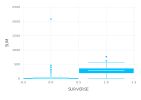

In [76]:
plot(df, x=:SURVERSE, y=:SUM, Geom.boxplot)

## Graphique du nombre de surverses selon le mois pour chaque ouvrage

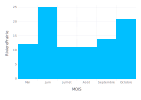

In [77]:
plot(X_mois, x=:MOIS, y=:RivierePrairie, Geom.bar)

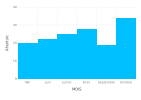

In [78]:
plot(X_mois, x=:MOIS, y=:Ahuntsic, Geom.bar)

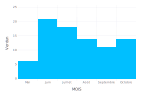

In [79]:
plot(X_mois, x=:MOIS, y=:Verdun, Geom.bar)

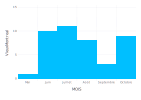

In [80]:
plot(X_mois, x=:MOIS, y=:VieuxMontreal, Geom.bar)

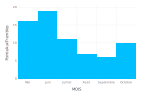

In [81]:
plot(X_mois, x=:MOIS, y=:PointeAuxTrembles, Geom.bar)

#### Traçage des distribution de la somme des précipitations en fonction des surverses ou non

On remarque que les deux distributions sont très différentes. Ceci suggère que le maximum journalier des précipitations à la station McTavish a un effet sur les surverses au Bota-Bota.

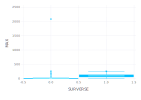

In [82]:
plot(df, x=:SURVERSE, y=:MAX, Geom.boxplot)

# Régression logistique à 5 variables explicatives pour l'ouvrage Vieux-Montréal

In [83]:
# Construction d'un dataframe contenant toutes les variables explicatives
ouvrage = "4350-01D"

df_test = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)

x₁ = Array{Int64}(undef, size(df_test,1)) # variable pour la somme journalière McTavish
x₂ = Array{Int64}(undef, size(df_test,1)) # variable pour la somme journalière Bellevue
x₃ = Array{Int64}(undef, size(df_test,1)) # variable pour la somme journalière Assomption
x₄ = Array{Int64}(undef, size(df_test,1)) # variable pour la somme journalière St-Hubert
x₅ = Array{Int64}(undef, size(df_test,1)) # variable pour la somme journalière PET


for i=1:size(df_test,1)
    
    ind = findfirst(pcp_sum[:,:date] .== df_test[i,:DATE])
    
    x₁[i] = pcp_sum[ind,:McTavish]
    
    x₂[i] = pcp_sum[ind,:Bellevue]
    
    x₃[i] = pcp_sum[ind,:Assomption]
    
    x₄[i] = pcp_sum[ind,:StHubert]
    
    x₅[i] = pcp_sum[ind,:Trudeau]
    
end

df_test[!,:SUMMcTavish] = x₁
df_test[!,:SUMBellevue] = x₂
df_test[!,:SUMAssomption] = x₃
df_test[!,:SUMStHubert] = x₄
df_test[!,:SUMPET] = x₅

first(df_test,5)

,NO_OUVRAGE,DATE,SURVERSE,SUMMcTavish,SUMBellevue,SUMAssomption,SUMStHubert
,String,Date,Int64,Int64,Int64,Int64,Int64
1,4350-01D,2013-05-01,0,0,0,0,0
2,4350-01D,2013-05-02,0,0,0,0,0
3,4350-01D,2013-05-03,0,0,0,0,0
4,4350-01D,2013-05-04,0,0,0,0,0
5,4350-01D,2013-05-05,0,0,0,0,0


In [84]:
# Séparation en ensemble de test et d'entraînement
train_set, test_set = splitdataframe(df_test, 0.7)

# Calcul des paramètres
M = glm(@formula(SURVERSE ~ SUMMcTavish + SUMBellevue + SUMAssomption + SUMStHubert + SUMPET), train_set,  Bernoulli(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Bernoulli{Float64},LogitLink},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

SURVERSE ~ 1 + SUMMcTavish + SUMBellevue + SUMAssomption + SUMStHubert + SUMPET

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                  Estimate  Std. Error     z value  Pr(>|z|)     Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)    -5.47376     0.494144    -11.0773      <1e-27  -6.44226      -4.50525   
SUMMcTavish     0.0133797   0.00582253    2.29792     0.0216   0.00196777    0.0247917 
SUMBellevue     0.00996482  0.00476494    2.09128     0.0365   0.000625709   0.0193039 
SUMAssomption   0.00124409  0.00321708    0.386715    0.6990  -0.00506127    0.00754946
SUMStHubert     0.00207274  0.00666013    0.311215    0.7556  -0.0109809     0.0151264 
SUMP

In [115]:
# Estimation de la probabilité de survie de chacun des passagers de l'ensemble de test
X̃ = hcat(ones(Float64,length(test_set[:,1])),test_set[:,:SUMMcTavish], test_set[:,:SUMBellevue], test_set[:,:SUMAssomption], test_set[:,:SUMStHubert], test_set[:,:SUMPET])
θ̂ = predict(M, X̃)

# Prédiction de la survie pour chacun des passagers de l'échantillon de test
Ŷ = zeros(Int64,length(test_set[:,1]))
Ŷ[θ̂.>.36] .= 1;

In [116]:
f1 = computeF1score(Ŷ, test_set[:, :SURVERSE])
print(f1)

0.6666666666666666

## Bayesien Naïf (Othman et Anis)

# Création du fichier de prédictions pour soumettre sur Kaggle

Dans ce cas-ci, nous prédirons une surverse avec une probabilité de 1/2 sans considérer aucune variable explicative.

In [28]:

# Chargement du fichier de test
test = CSV.read("data/test.csv")

# Pour chacune des lignes du fichier test, comportant un ouvrage et une date, une prédiction est requise.
# Dans ce cas-ci, utilisons une prédiction les plus naîve. 
# On prédit avec une chance sur deux qu'il y ait surverse, sans utiliser de variables explicatives
n = size(test,1)
surverse = rand(n) .> .5


# Création du fichier sampleSubmission.csv pour soumettre sur Kaggle
ID = test[:,:NO_OUVRAGE].*"_".*string.(test[:,:DATE])
sampleSubmission = DataFrame(ID = ID, Surverse=surverse)
CSV.write("sampleSubmission.csv",sampleSubmission)

# Vous pouvez par la suite déposer le fichier sampleSubmission.csv sur Kaggle.


"sampleSubmission.csv"